### Importing Libraries

In [1]:
import sys
import os
import math
import time
import pandas as pd
from glob import iglob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix

### Importing dataset

In [2]:
benign=pd.read_csv("SimpleHome_XCS7_1002_WHT_Security_Camera/benign_traffic.csv")
x_train, x_opt, x_test = np.split(benign.sample(frac=1, random_state=20), [int(1/3*len(benign)), int(2/3*len(benign))])

df_mirai = pd.concat((pd.read_csv(f) for f in iglob('SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/*.csv', recursive=False)), ignore_index=True)
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/*.csv', recursive=False)), ignore_index=True)

In [3]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 'malicious'

df_ben = x_train.copy()
df_ben['class'] = 'benign'

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=20))

### Plotting samples of benign and malicious data

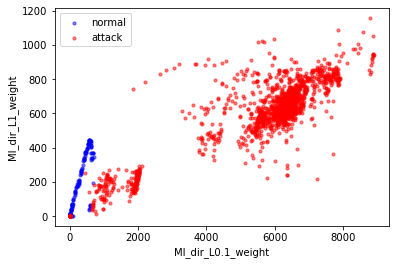

In [4]:
plot_n = 2000
atk = df_attack.sample(n=plot_n, random_state=76)
nrm = x_train.sample(n=plot_n, random_state=42)

fig, ax1 = plt.subplots()

ax1.scatter(nrm['MI_dir_L0.1_weight'],nrm['MI_dir_L1_weight'],10,c='blue', label='normal',alpha=0.5)
ax1.scatter(atk['MI_dir_L0.1_weight'],atk['MI_dir_L1_weight'],10,c='red',label='attack',alpha=0.5)

plt.xlabel('MI_dir_L0.1_weight')
plt.ylabel('MI_dir_L1_weight')

plt.legend()
plt.show()

In [5]:
classes = ['benign','malicious']
scored = []
indices = {}
shps = {}

#classifying benign as true and attack as false
for cl in classes:
    indices[cl] = df_ben['class'] == cl    
    shps[cl] =  df_ben[indices[cl]].shape[0]
        
for col in df_ben.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = df_ben[col].mean()
    
    for cl in classes:
        num += (shps[cl] / df_ben.shape[0]) * (m - df_ben[indices[cl]][col].mean())**2
        den += (shps[cl] / df_ben.shape[0]) * df_ben[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:5]

[{'feature': 'MI_dir_L0.1_weight', 'score': 1.1394566521439042},
 {'feature': 'H_L0.1_weight', 'score': 1.1394555357208591},
 {'feature': 'MI_dir_L1_weight', 'score': 1.0159791903790414},
 {'feature': 'H_L1_weight', 'score': 1.0159786430763942},
 {'feature': 'MI_dir_L3_weight', 'score': 0.8699374428709418}]

### Predicting Anomaly

In [6]:
class AnomalyModel:
    #initialize model
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    #predict the outcome using treshold
    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)
    
    #scale the classes
    def scale_predict_classes(self, x):
        x = self.scaler.transform(x)
        y_pred = self.predict(x)
        classes_arr = []
        for e in y_pred:
            el = [0,0]
            el[e] = 1
            classes_arr.append(el)
        print(classes_arr)

        return np.array(classes_arr)

### Model creation - Deep autoencoder

In [7]:
def deep_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.25 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

### Fit model

In [8]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = deep_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly{top_n_features}.h5",monitor='val_loss',save_best_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs,
                    validation_data=(X_opt, X_opt),
                    verbose=1,
                    callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary())    

Epoch 1/100
486/486 [==============================] - 3s 5ms/step - loss: 0.4881 - val_loss: 0.4146
Epoch 2/100
486/486 [==============================] - 1s 2ms/step - loss: 0.1598 - val_loss: 0.3628
Epoch 3/100
486/486 [==============================] - 1s 2ms/step - loss: 0.1126 - val_loss: 0.3366
Epoch 4/100
486/486 [==============================] - 1s 3ms/step - loss: 0.0943 - val_loss: 0.3180
Epoch 5/100
486/486 [==============================] - 1s 2ms/step - loss: 0.0719 - val_loss: 0.2994
Epoch 6/100
486/486 [==============================] - 1s 3ms/step - loss: 0.0550 - val_loss: 0.2881
Epoch 7/100
486/486 [==============================] - 1s 2ms/step - loss: 0.0371 - val_loss: 0.2783
Epoch 8/100
486/486 [==============================] - 1s 2ms/step - loss: 0.0879 - val_loss: 0.2645
Epoch 9/100
486/486 [==============================] - 1s 2ms/step - loss: 0.0449 - val_loss: 0.2564
Epoch 10/100
486/486 [==============================] - 1s 2ms/step - loss: 0.0395 - val_lo

### Predict train dataset

In [9]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        
        #accs.append({'acc': acc, 'n': top_n_features, 'cm': confusion_matrix(Y_test, Y_pred)})

Selecting n------------------
For n 1
Accuracy
0.880280783101494
Precision 0.9994079837618404
Recall 0.7610123647604328
Confusion Matrix [[15521     7]
 [ 3711 11817]]
For n 2
Accuracy
0.8763523956723338
Precision 0.9994871794871795
Recall 0.7530911901081917
Confusion Matrix [[15522     6]
 [ 3834 11694]]
For n 3
Accuracy
0.8730358062854199
Precision 0.999482624816763
Recall 0.7464580113343637
Confusion Matrix [[15522     6]
 [ 3937 11591]]
For n 4
Accuracy
0.868753219989696
Precision 0.9997381742014313
Recall 0.737699639361154
Confusion Matrix [[15525     3]
 [ 4073 11455]]
For n 5
Accuracy
0.8635690365790829
Precision 0.9997344427724174
Recall 0.7273312725399279
Confusion Matrix [[15525     3]
 [ 4234 11294]]
For n 6
Accuracy
0.85448866563627
Precision 0.9998183964405702
Recall 0.7091061308603812
Confusion Matrix [[15526     2]
 [ 4517 11011]]
For n 7
Accuracy
0.8508178773827924
Precision 0.9998164969263235
Recall 0.7017645543534261
Confusion Matrix [[15526     2]
 [ 4631 10897]]
For

### Test data

In [10]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
deep_tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
deep_acc = accuracy_score(Y_test, Y_pred)
deep_precision = precision_score(Y_test, Y_pred)
deep_recall = recall_score(Y_test, Y_pred)
deep_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',deep_acc)
print('Precision ',deep_precision)
print("Recall",deep_recall)
print('Confusion Matrix',deep_cm)
   
#print(accs)

Test-----------------
best n 1
Treshold  448.35397879481826
Accuracy  0.8040762444458754
Precision  0.9998941350836332
Recall 0.6082168845386052
Confusion Matrix [[15528     1]
 [ 6084  9445]]


### Variational Autoencoder

In [11]:
def vae_model(input_dim):
    original_dim = input_dim
    intermediate_dim = 64
    latent_dim = 2

    inputs = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    from keras import backend as K

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling)([z_mean, z_log_sigma])

    # Create encoder
    encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

    # Create decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    return Model(inputs, outputs, name='vae_mlp')


In [12]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = vae_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_vae.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
486/486 [==============================] - 2s 3ms/step - loss: 0.8866 - val_loss: 1.0005
Epoch 2/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7488 - val_loss: 0.9915
Epoch 3/100
486/486 [==============================] - 1s 2ms/step - loss: 0.6850 - val_loss: 0.9901
Epoch 4/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7083 - val_loss: 0.9892
Epoch 5/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7057 - val_loss: 0.9883
Epoch 6/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7277 - val_loss: 0.9888
Epoch 7/100
486/486 [==============================] - 1s 2ms/step - loss: 0.6955 - val_loss: 0.9886
Epoch 8/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7219 - val_loss: 0.9869
Epoch 9/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7068 - val_loss: 0.9870
Epoch 10/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7425 - val_lo

### Train

In [13]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.8812789799072643
Precision 0.9982327695026508
Recall 0.7639103554868625
Confusion Matrix [[15507    21]
 [ 3666 11862]]
For n 2
Accuracy
0.8760947964966512
Precision 0.9992306377158489
Recall 0.7527691911385883
Confusion Matrix [[15519     9]
 [ 3839 11689]]
For n 3
Accuracy
0.8711038124678001
Precision 0.99930681916645
Recall 0.7427228232869655
Confusion Matrix [[15520     8]
 [ 3995 11533]]
For n 4
Accuracy
0.8640520350334879
Precision 0.999293411058117
Recall 0.728619268418341
Confusion Matrix [[15520     8]
 [ 4214 11314]]
For n 5
Accuracy
0.8530074703760948
Precision 0.9993623029971759
Recall 0.7064657393096342
Confusion Matrix [[15521     7]
 [ 4558 10970]]
For n 6
Accuracy
0.8494976816074189
Precision 0.999355907250644
Recall 0.6994461617722824
Confusion Matrix [[15521     7]
 [ 4667 10861]]
For n 7
Accuracy
0.8467928902627512
Precision 0.9993508902077152
Recall 0.6940365790829469
Confusion Matrix [[15521     7]
 [ 4751 10777]]
Fo

### Test

In [14]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
vae_acc = accuracy_score(Y_test, Y_pred)
vae_precision = precision_score(Y_test, Y_pred)
vae_recall = recall_score(Y_test, Y_pred)
vae_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',vae_acc)
print('Precision ',vae_precision)
print("Recall",vae_recall)
print('Confusion Matrix',vae_cm)

Test-----------------
best n 1
Treshold  24.296960242198608
Accuracy  0.8790327773842488
Precision  0.9974645030425964
Recall 0.7599974241741259
Confusion Matrix [[15499    30]
 [ 3727 11802]]


### Undercomplete Autoencoder

In [15]:
def uc_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(15, activation='relu')(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [16]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = uc_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_undercomplete.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
486/486 [==============================] - 1s 2ms/step - loss: 0.9453 - val_loss: 0.9899
Epoch 2/100
486/486 [==============================] - 1s 1ms/step - loss: 0.7244 - val_loss: 0.9728
Epoch 3/100
486/486 [==============================] - 1s 2ms/step - loss: 0.6797 - val_loss: 0.9668
Epoch 4/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7026 - val_loss: 0.9640
Epoch 5/100
486/486 [==============================] - 1s 1ms/step - loss: 0.6878 - val_loss: 0.9622
Epoch 6/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7034 - val_loss: 0.9608
Epoch 7/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7019 - val_loss: 0.9600
Epoch 8/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7072 - val_loss: 0.9593
Epoch 9/100
486/486 [==============================] - 1s 1ms/step - loss: 0.6669 - val_loss: 0.9586
Epoch 10/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7113 - val_lo

In [17]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.881053580628542
Precision 0.9984835720303286
Recall 0.7632663575476558
Confusion Matrix [[15510    18]
 [ 3676 11852]]
For n 2
Accuracy
0.8761269963936116
Precision 0.9993160639480209
Recall 0.7527691911385883
Confusion Matrix [[15520     8]
 [ 3839 11689]]
For n 3
Accuracy
0.8710716125708398
Precision 0.9993067590987869
Recall 0.7426584234930448
Confusion Matrix [[15520     8]
 [ 3996 11532]]
For n 4
Accuracy
0.8640520350334879
Precision 0.999293411058117
Recall 0.728619268418341
Confusion Matrix [[15520     8]
 [ 4214 11314]]
For n 5
Accuracy
0.8531040700669758
Precision 0.9993624772313296
Recall 0.7066589386913962
Confusion Matrix [[15521     7]
 [ 4555 10973]]
For n 6
Accuracy
0.8496264811952602
Precision 0.9993561442236939
Recall 0.6997037609479649
Confusion Matrix [[15521     7]
 [ 4663 10865]]
For n 7
Accuracy
0.8470182895414735
Precision 0.9993513112779168
Recall 0.6944873776403916
Confusion Matrix [[15521     7]
 [ 4744 10784]]


In [18]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
uc_acc = accuracy_score(Y_test, Y_pred)
uc_precision = precision_score(Y_test, Y_pred)
uc_recall = recall_score(Y_test, Y_pred)
uc_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',uc_acc)
print('Precision ',uc_precision)
print("Recall",uc_recall)
print('Confusion Matrix',uc_cm)

Test-----------------
best n 1
Treshold  24.258207484916756
Accuracy  0.8788073926202589
Precision  0.9974630021141649
Recall 0.7595466546461459
Confusion Matrix [[15499    30]
 [ 3734 11795]]


### Sparse Autoencoder

In [19]:
def sparse_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(200, activation='relu',
                activity_regularizer=regularizers.l1(10e-6))(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [20]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = sparse_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
486/486 [==============================] - 1s 2ms/step - loss: 0.8149 - val_loss: 0.9625
Epoch 2/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7024 - val_loss: 0.9573
Epoch 3/100
486/486 [==============================] - 1s 2ms/step - loss: 0.6867 - val_loss: 0.9553
Epoch 4/100
486/486 [==============================] - 1s 2ms/step - loss: 0.6541 - val_loss: 0.9544
Epoch 5/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7209 - val_loss: 0.9540
Epoch 6/100
486/486 [==============================] - 1s 2ms/step - loss: 0.6624 - val_loss: 0.9539
Epoch 7/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7166 - val_loss: 0.9535
Epoch 8/100
486/486 [==============================] - 1s 2ms/step - loss: 0.7022 - val_loss: 0.9534
Epoch 9/100
486/486 [==============================] - 1s 2ms/step - loss: 0.6744 - val_loss: 0.9533
Epoch 10/100
486/486 [==============================] - 1s 2ms/step - loss: 0.6643 - val_lo

In [21]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.8809247810407007
Precision 0.9984830608461149
Recall 0.7630087583719732
Confusion Matrix [[15510    18]
 [ 3680 11848]]
For n 2
Accuracy
0.8761269963936116
Precision 0.9993160639480209
Recall 0.7527691911385883
Confusion Matrix [[15520     8]
 [ 3839 11689]]
For n 3
Accuracy
0.8704598145285936
Precision 0.999305615831959
Recall 0.7414348274085523
Confusion Matrix [[15520     8]
 [ 4015 11513]]
For n 4
Accuracy
0.8632148377125193
Precision 0.9992917847025495
Recall 0.7269448737764039
Confusion Matrix [[15520     8]
 [ 4240 11288]]
For n 5
Accuracy
0.8529108706852138
Precision 0.9993621286677602
Recall 0.7062725399278722
Confusion Matrix [[15521     7]
 [ 4561 10967]]
For n 6
Accuracy
0.8495942812982998
Precision 0.9993560849967804
Recall 0.6996393611540443
Confusion Matrix [[15521     7]
 [ 4664 10864]]
For n 7
Accuracy
0.8469538897475528
Precision 0.9993511910278988
Recall 0.6943585780525502
Confusion Matrix [[15521     7]
 [ 4746 10782]

In [22]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
sparse_acc = accuracy_score(Y_test, Y_pred)
sparse_precision = precision_score(Y_test, Y_pred)
sparse_recall = recall_score(Y_test, Y_pred)
sparse_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',sparse_acc)
print('Precision ',sparse_precision)
print("Recall",sparse_recall)
print('Confusion Matrix',sparse_cm)

Test-----------------
best n 1
Treshold  24.25414027696972
Accuracy  0.8787107991499774
Precision  0.997462358315006
Recall 0.7593534677055831
Confusion Matrix [[15499    30]
 [ 3737 11792]]


### Denoising Autoencoder

In [23]:
def denoise_model(input_dim):
    input_size = input_dim
    hidden_size = 44
    code_size = 5

    input_img = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_img = Dense(input_size, activation='sigmoid')(hidden_2)

    autoencoder = Model(input_img, output_img)
    return autoencoder

In [24]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()

noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_opt_noisy = np.clip(x_opt_noisy, 0., 1.)

X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
#x_train_noisy = scaler.fit_transform(x_train_noisy)
#x_opt_noisy = scaler.transform(x_opt_noisy)

#call function to create the model
model = denoise_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(x_train_noisy, X_train,
                    epochs=epochs, validation_data=(x_opt_noisy, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
486/486 [==============================] - 1s 2ms/step - loss: 1.0583 - val_loss: 1.2292
Epoch 2/100
486/486 [==============================] - 1s 2ms/step - loss: 0.9244 - val_loss: 1.1939
Epoch 3/100
486/486 [==============================] - 1s 2ms/step - loss: 0.9182 - val_loss: 1.1761
Epoch 4/100
486/486 [==============================] - 1s 2ms/step - loss: 0.8552 - val_loss: 1.1710
Epoch 5/100
486/486 [==============================] - 1s 2ms/step - loss: 0.9256 - val_loss: 1.1682
Epoch 6/100
486/486 [==============================] - 1s 2ms/step - loss: 0.8882 - val_loss: 1.1673
Epoch 7/100
486/486 [==============================] - 1s 2ms/step - loss: 0.8936 - val_loss: 1.1661
Epoch 8/100
486/486 [==============================] - 1s 2ms/step - loss: 0.8543 - val_loss: 1.1660
Epoch 9/100
486/486 [==============================] - 1s 2ms/step - loss: 0.8491 - val_loss: 1.1657
Epoch 10/100
486/486 [==============================] - 1s 2ms/step - loss: 0.9145 - val_lo

In [25]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(x_opt_noisy)
mse = np.mean(np.power(x_opt_noisy - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
X_opt_scaled = scaler.transform(x_opt_noisy)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.7150631117980423
Precision 0.6369938876810108
Recall 1.0
Confusion Matrix [[ 6679  8849]
 [    0 15528]]
For n 2
Accuracy
0.7927614631633179
Precision 0.7069750500819523
Recall 1.0
Confusion Matrix [[ 9092  6436]
 [    0 15528]]
For n 3
Accuracy
0.8550360638845955
Precision 0.7752371442835746
Recall 1.0
Confusion Matrix [[11026  4502]
 [    0 15528]]
For n 4
Accuracy
0.8934827408552293
Precision 0.8243788490125292
Recall 1.0
Confusion Matrix [[12220  3308]
 [    0 15528]]
For n 5
Accuracy
0.9202086553323029
Precision 0.8624194623417019
Recall 0.9999356002060793
Confusion Matrix [[13051  2477]
 [    1 15527]]
For n 6
Accuracy
0.934473209685729
Precision 0.8841751608678321
Recall 0.9999356002060793
Confusion Matrix [[13494  2034]
 [    1 15527]]
For n 7
Accuracy
0.9431993817619784
Precision 0.8980335454019664
Recall 0.9999356002060793
Confusion Matrix [[13765  1763]
 [    1 15527]]
For n 8
Accuracy
0.9483513652756311
Precision 0.9064214827

In [26]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(x_test_noisy, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=20)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
X_test_scaled = scaler.transform(x_test_noisy)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Treshold ",tr)
denoise_acc = accuracy_score(Y_test, Y_pred)
denoise_precision = precision_score(Y_test, Y_pred)
denoise_recall = recall_score(Y_test, Y_pred)
denoise_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',denoise_acc)
print('Precision ',denoise_precision)
print("Recall",denoise_recall)
print('Confusion Matrix',denoise_cm)

Test-----------------
best n 29
Treshold  6.144931528089354
Accuracy  0.9996136261188744
Precision  0.9992278489157712
Recall 1.0
Confusion Matrix [[15517    12]
 [    0 15529]]


### Deep Neural Net

In [27]:
def dnn_model(inputs):
    model = Sequential()
    model.add(Dense(115, input_dim=inputs, activation='relu'))
    model.add(Dense(80, input_dim=inputs, activation='relu'))
    model.add(Dense(10, input_dim=inputs, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(labels.shape[1],activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', min_delta=1e-3, callbacks=[monitor], patience=5) 
    model.fit(x_train_st,y_train_st,validation_data=(x_test_st,y_test_st),
          verbose=1,epochs=100, callbacks=[es])

In [28]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 1

df_ben = x_train.copy()
df_ben['class'] = 0

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=17))

X = df_ben.drop(columns=['class'])
y = df_ben['class']

In [29]:
#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=17)

#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [30]:
#create model
model = Sequential()
model.add(Dense(115, input_dim=115, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100

#compile and fit model
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train,y_train,epochs=epochs,batch_size=15,callbacks=[es])

end = time.time()
print("time",end-start)

Epoch 1/100
1657/1657 [==============================] - 2s 1ms/step - loss: 0.0108
Epoch 2/100
1657/1657 [==============================] - 2s 1ms/step - loss: 0.0016
Epoch 3/100
1657/1657 [==============================] - 2s 1ms/step - loss: 0.0015
Epoch 4/100
1657/1657 [==============================] - 2s 1ms/step - loss: 5.3902e-04
Epoch 5/100
1657/1657 [==============================] - 2s 1ms/step - loss: 0.0018
Epoch 6/100
1657/1657 [==============================] - 2s 1ms/step - loss: 4.9696e-04
Epoch 7/100
1657/1657 [==============================] - 2s 1ms/step - loss: 9.9354e-04
Epoch 8/100
1657/1657 [==============================] - 2s 1ms/step - loss: 7.6701e-04
Epoch 9/100
1657/1657 [==============================] - 2s 1ms/step - loss: 4.7829e-04
time 15.716485977172852


In [31]:
predictions = model.predict(X_test)
y_pred = [round(x[0]) for x in predictions]

In [32]:
dnn_acc = accuracy_score(y_test, y_pred)
dnn_precision = precision_score(y_test, y_pred)
dnn_recall = recall_score(y_test, y_pred)
dnn_cm = confusion_matrix(y_test, y_pred)
print('Accuracy ',dnn_acc)
print('Precision ',dnn_precision)
print("Recall",dnn_recall)
print('Confusion Matrix',dnn_cm)

Accuracy  0.9995170637475853
Precision  0.999347045380346
Recall 0.9996734160679295
Confusion Matrix [[3148    2]
 [   1 3061]]


### Model comparison

In [34]:
print("SimpleHome_XCS7_1002_WHT_Security_Camera")
model_summary = pd.DataFrame({'Model' :['Deep AutoEncoder',"Variational AutoEncoder","Sparse AutoEncoder","Undercomplete Autoencoder","Denoising Autoendoer"],
                             'Accuracy':[deep_acc,vae_acc,sparse_acc,uc_acc,denoise_acc],
                             'Precision':[deep_precision,vae_precision,sparse_precision,uc_precision,denoise_precision],
                             'Recall':[deep_recall,vae_recall,sparse_recall,uc_recall,denoise_recall],
                             'CM':[deep_cm,vae_cm,sparse_cm,uc_cm, denoise_cm]})
model_summary.sort_values(by='Accuracy', ascending=True)

SimpleHome_XCS7_1002_WHT_Security_Camera


,Model,Accuracy,Precision,Recall,CM
0,Deep AutoEncoder,0.804076,0.999894,0.608217,"[[15528, 1], [6084, 9445]]"
2,Sparse AutoEncoder,0.878711,0.997462,0.759353,"[[15499, 30], [3737, 11792]]"
3,Undercomplete Autoencoder,0.878807,0.997463,0.759547,"[[15499, 30], [3734, 11795]]"
1,Variational AutoEncoder,0.879033,0.997465,0.759997,"[[15499, 30], [3727, 11802]]"
4,Denoising Autoendoer,0.999614,0.999228,1.000000,"[[15517, 12], [0, 15529]]"
